# Studying FEL UQ - Creating Basic NN Models with Quantile Regression

In [3]:
%load_ext autoreload
%autoreload 2


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import basicFunctions as bf

### Colorblind friendly colors:

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]


import matplotlib.style
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}
mpl.rc('font', **font)


import QuantRegUtils as qru

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Data

In [4]:
PATH = "datasets/"
NAME = "compiled_"
inputdf = pd.read_csv(PATH + NAME +'X.csv') 
outputdf = pd.read_csv(PATH + NAME + 'Y.csv') 

#### Take a look at the input variables

In [5]:
variable_names = inputdf.columns[1:]

output_names = outputdf.columns[1:]

view = False
## View the names and indicies of each variable
if view:
    for i, v in enumerate(variable_names):
        print(i, v)

#### Data manipulations

The following cell converts the dataframe to numpy arrays and applies the following cuts to the data: 

1) Removing extraneous data: no output values should be less than 0 (units) or greater than 5 (units).

2) For looking at hard X-rays (HXR), only use data generated from electron beams with energy greater than 14GeV

In [6]:
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]

print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))

## For HXR, use col 8 (BEND_DMP1_400_BDES), to take data above 14GeV

mask = np.where(input_data[:,8] > 14)

input_data = input_data[mask[0],:]
output_data = output_data[mask]
n = np.shape(output_data)[0]


print("Final shape of data, after cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))


Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data or selected HXR samples:
Input values: (162619, 76)
Output values: (162619,)


#### Scaling information will be needed later, should be saved and set up for use in training and model eval.

In [7]:
PATH = ""
MODEL_NAME = "HXR/"
loading = True

if loading:
    x_scales = np.load(PATH + MODEL_NAME + "x_scales.npy")
    x_offsets = np.load(PATH + MODEL_NAME +"x_offsets.npy")
    y_scale = np.load(PATH + MODEL_NAME +"y_scale.npy")
    y_offset = np.load(PATH + MODEL_NAME +"y_offset.npy")
    x_scaled = np.load(PATH + MODEL_NAME + "x_scaled.npy")
    y_scaled = np.load(PATH + MODEL_NAME + "y_scaled.npy")
else:
    x_scaled, x_scales, x_offsets = bf.do_scaling(input_data, -1, 1)
    y_offset, y_scale= bf.get_scale(output_data)

    y_scaled = bf.scale_data(output_data, y_offset, y_scale, -1,1)
    
    np.save(PATH + MODEL_NAME + "x_scales.npy", x_scales)
    np.save(PATH + MODEL_NAME + "x_offsets.npy", x_offsets)
    np.save(PATH + MODEL_NAME + "y_scale.npy", y_scale)
    np.save(PATH + MODEL_NAME + "y_offset.npy", y_offset)
    np.save(PATH + MODEL_NAME + "x_scaled.npy", x_scaled)
    np.save(PATH + MODEL_NAME + "y_scaled.npy", y_scaled)

x, y, d = qru.scaling_and_dict(input_data, output_data)

#### Examine Data

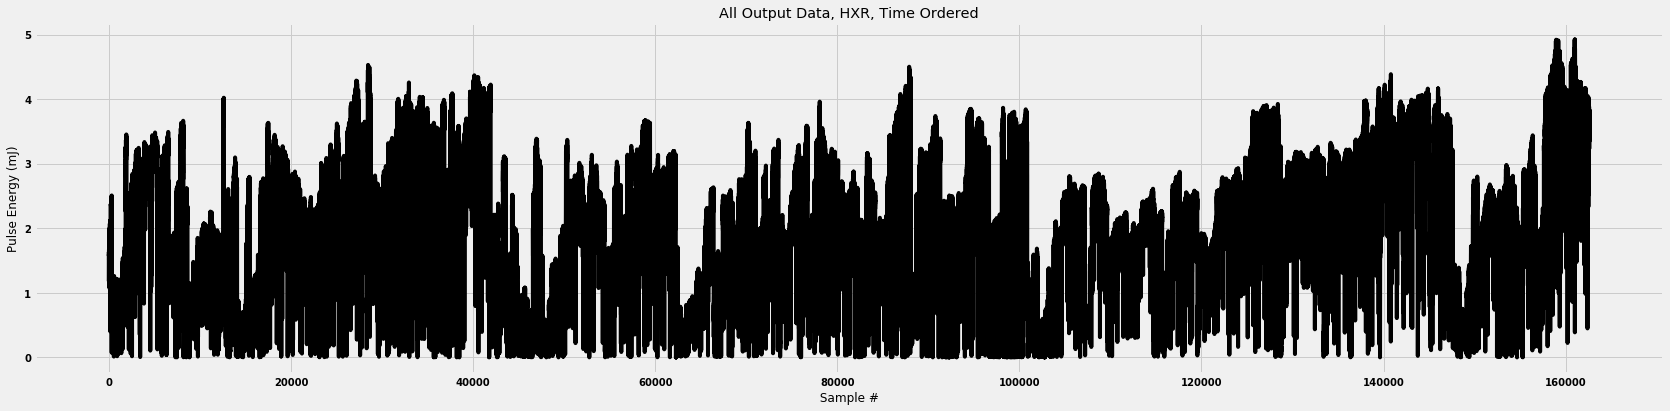

In [8]:
## Take a look at all of the output data
plt.figure(figsize= (26,6))
plt.plot(output_data, color = colors[0])
plt.ylabel("Pulse Energy (mJ)")
plt.xlabel(" Sample # ")
plt.title("All Output Data, HXR, Time Ordered")
plt.show()

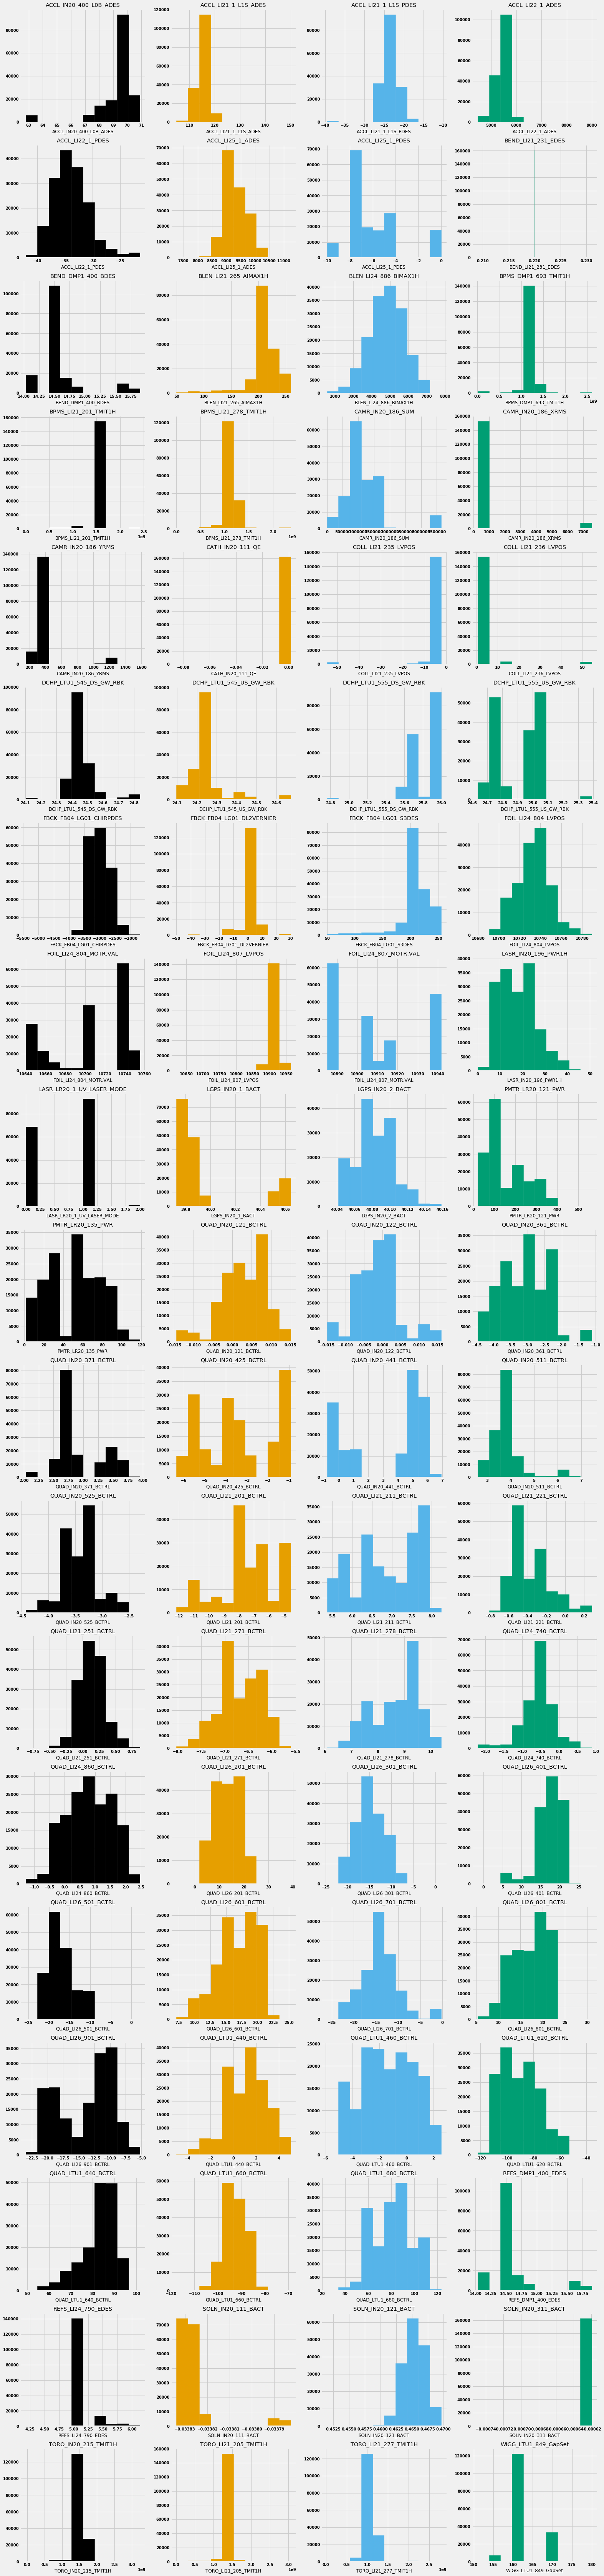

In [9]:
fig, axs = plt.subplots(19, 4, figsize = (24,int(6*19)))
counter = 0
for i in range(19):
    for j in range(4):

        axs[i,j].hist(input_data[:,counter], facecolor = colors[j], ec= colors[j])
        axs[i,j].set_title(variable_names[counter])
        axs[i,j].set_xlabel(variable_names[counter])
        counter = counter + 1
        plt.suptitle("")

plt.show()

#### Load base models (all beam energies) and see how the model performs

In [10]:
## For loading models


PATH = ""
MODEL_NAME = "BaseModels/"
NN = MODEL_NAME + "median_pred_Model_Weights.h5"
LB = MODEL_NAME + "lower_pred_Model_Weights.h5"
UB = MODEL_NAME + "upper_pred_Model_Weights.h5"

    
nn = qru.Model(PATH = PATH, NAME = NN, scaling_dict = d)   
nn.load()

ub = qru.Model(PATH = PATH, NAME = UB, scaling_dict = d)   
ub.load()

lb = qru.Model(PATH = PATH, NAME = LB, scaling_dict = d)   
lb.load()


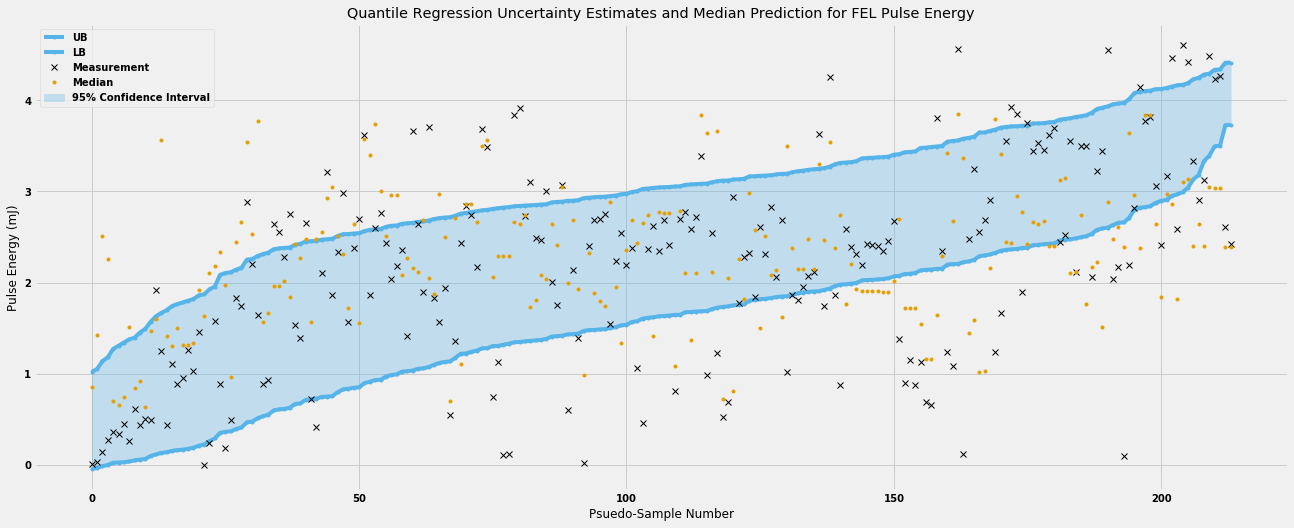

In [11]:
inps = input_data[:,:]
out = output_data[:]

median_pred = nn.evaluate(inps)
ub_pred = ub.evaluate(inps)
lb_pred = lb.evaluate(inps)

qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, out)

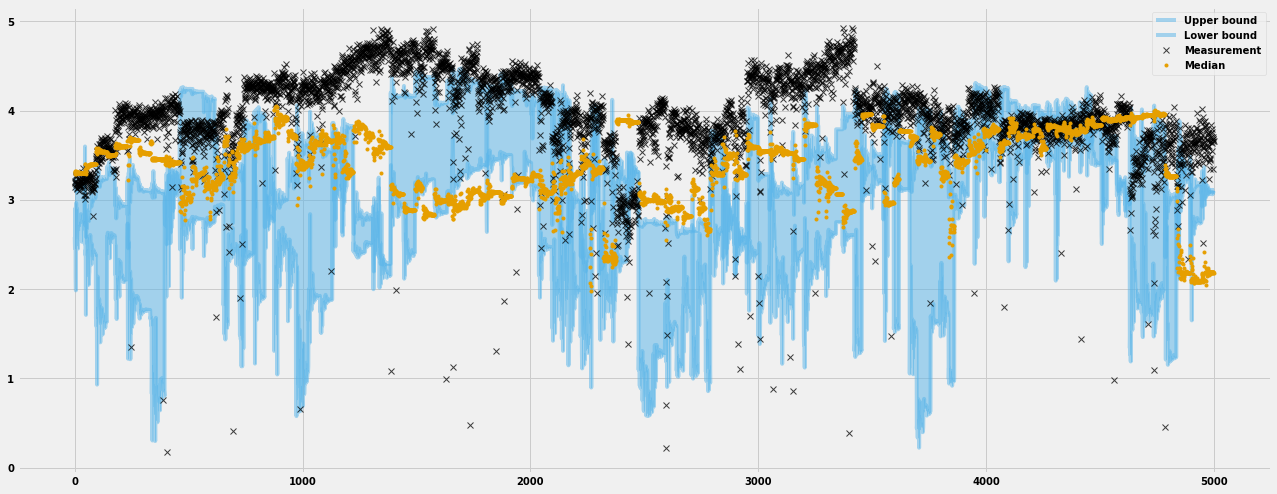

In [12]:
qru.basic_plotting(ub_pred[-5000:,:], lb_pred[-5000:,:], median_pred[-5000:,:], out[-5000:])

## Input Interpolation Study

Two of the ~ 30 quadrupole magnets in this machine have a fairly strong effect on the output pulse energy (one determined by evaluating the maximum information coefficient, and the other from operator experience.) For these quadrupoles, we can cut out a range of input data for one quad a time, and see how well the model is able to interpolate. 

For this exercise, it is best to use the scaled inputs and outputs, which were calculated earlier in the notebook (x_scaled and y_scaled).

Hint: To determine the column # (since we are working with arrays), it is best to scroll up and view the variables with their index.

#### Looking at QUAD_LI21_201_BCTRL

Cutting on: QUAD_LI21_201_BCTRL
Number of samples removed: 60989


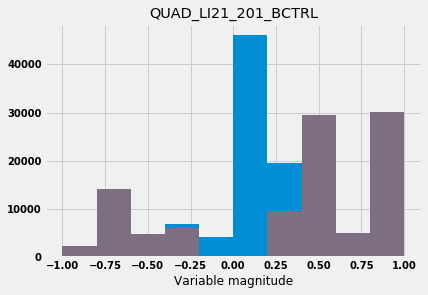

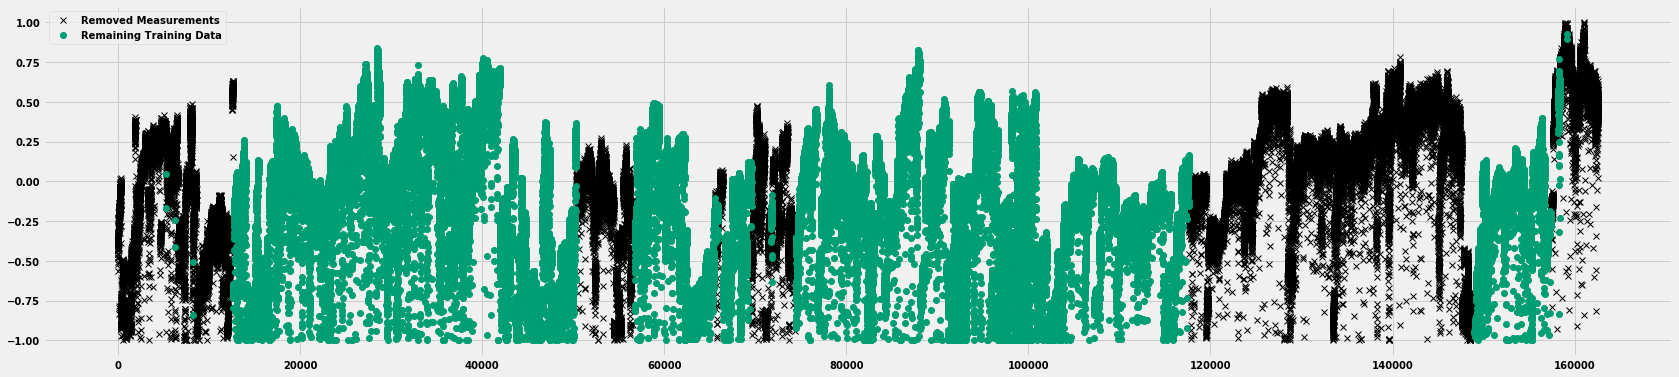

In [13]:
column = 45

## Remember these values must be [-1,1] and a must be less than b.
a = -0.25
b = 0.25

allinds, remaining, xinds, xs, ys = qru.make_data_cuts(x_scaled, y_scaled, column, a, b, variable_names, verbose = True)

plt.figure(figsize = (26, 6))
plt.plot(xinds[0], y_scaled[xinds], 'x', color = colors[0], label = "Removed Measurements")
plt.plot(remaining, ys, '.', color = colors[-3], markersize = 12, label = "Remaining Training Data")
plt.legend()
plt.show()

q45 = qru.make_cut_dict(column, a, b, allinds, remaining, xinds, xs, ys)




Now the data is ready to be trained on, and the predictions evaluated. The data is stored in a dictionary identified by the quad position in the input matrix. 

If you have already trainied models (or want to use the pre-trained ones, flip the training switch:)

In [14]:
training_models = False


PATH = ""
MODEL_NAME = "HXR/" + str(variable_names[column])+"_"
NN = MODEL_NAME + "median_pred_Model_Weights.h5"
LB = MODEL_NAME + "lower_pred_Model_Weights.h5"
UB = MODEL_NAME + "upper_pred_Model_Weights.h5"

if training_models:

    epochs = 5000
    batch_size = 4096
    PATH = "/global/cfs/cdirs/m669/lgupta/datasets/FEL/HXR/"



    median_q45 = qru.Model(scaling_dict = d, PATH = PATH, NAME = str(variable_names[column])+"_median_pred_", QUANTILE = 0.5)
    median_q45.train(q45["xs"], q45["ys"], epochs = epochs, batch_size = batch_size)
    print("Completed")

    upper_q45 = qru.Model(scaling_dict = d, PATH = PATH, NAME = str(variable_names[column])+"_upper_pred_", QUANTILE = 0.975)
    upper_q45.train(q45["xs"], q45["ys"], epochs = epochs, batch_size = batch_size)
    print("Completed")

    lower_q45 = qru.Model(scaling_dict = d, PATH = PATH, NAME = str(variable_names[column])+"_lower_pred_", QUANTILE = 0.025)
    lower_q45.train(q45["xs"], q45["ys"], epochs = epochs, batch_size = batch_size)
    print("Completed")
    
else:
    
    median_q45 = qru.Model(PATH = PATH, NAME = NN, scaling_dict = d)   
    median_q45.load()

    ub_q45 = qru.Model(PATH = PATH, NAME = UB, scaling_dict = d)   
    ub_q45.load()

    lb_q45 = qru.Model(PATH = PATH, NAME = LB, scaling_dict = d)   
    lb_q45.load()
    print("Models Loaded")

Models Loaded


In [15]:
inps = input_data
out = output_data
median_pred = median_q45.evaluate(inps)
ub_pred = ub_q45.evaluate(inps)
lb_pred = lb_q45.evaluate(inps)

/global/homes/l/lgupta/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


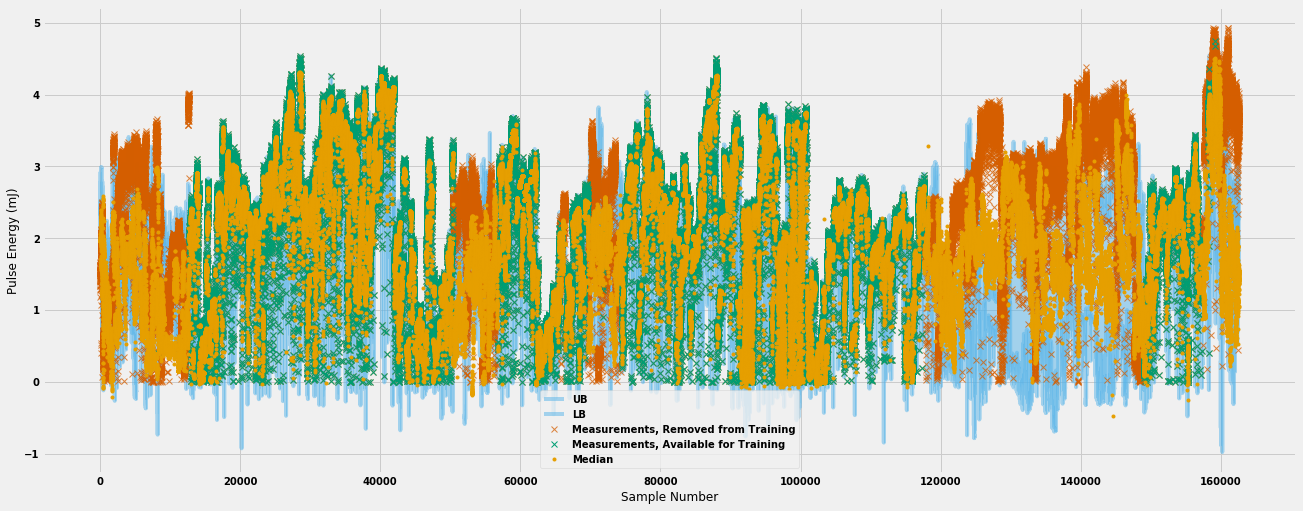

In [16]:
qru.plot_interpolation_predictions(ub_pred, lb_pred, median_pred, out, output_data, q45["remaining"])

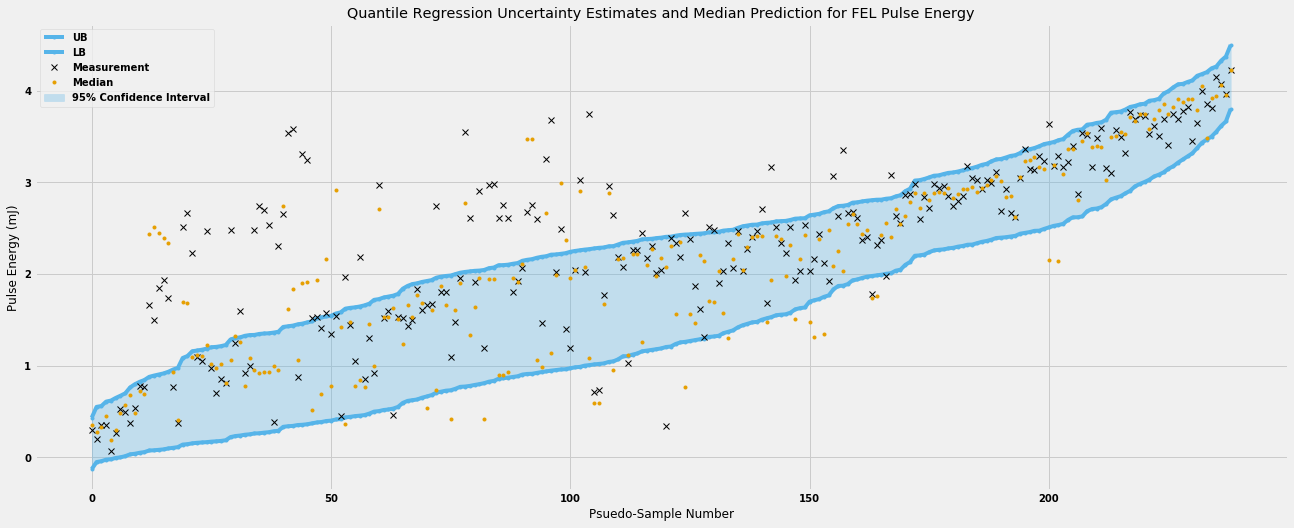

In [17]:
qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, out)

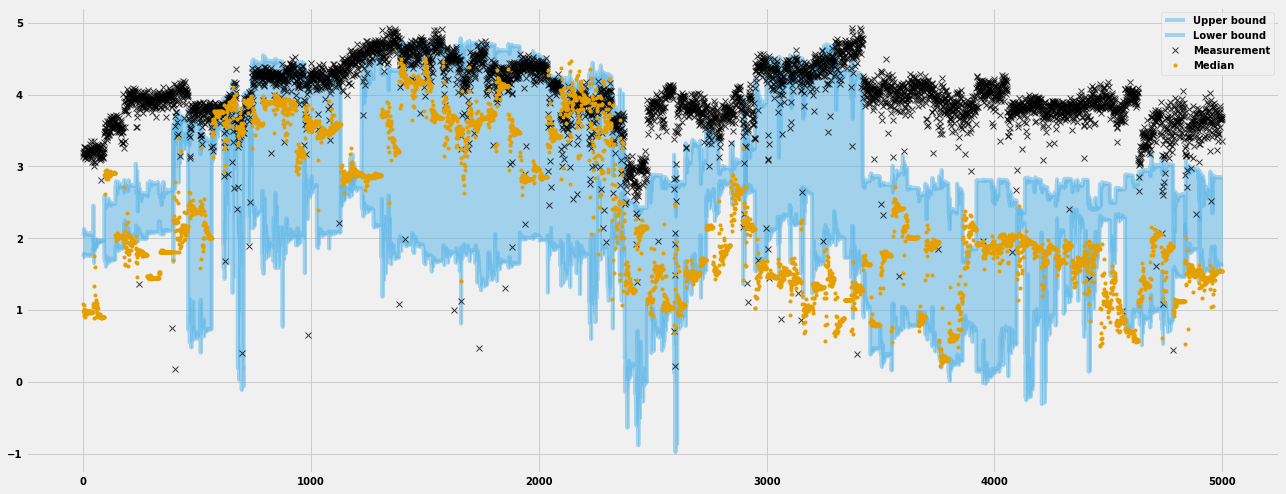

In [18]:
qru.basic_plotting(ub_pred[-5000:,:], lb_pred[-5000:,:], median_pred[-5000:,:], out[-5000:])

#### Looking at QUAD_LTU1_620_BCTRL

Cutting on: QUAD_LTU1_620_BCTRL
Number of samples removed: 68560


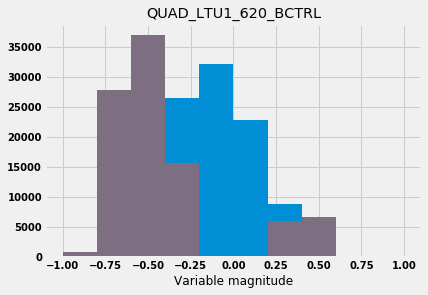

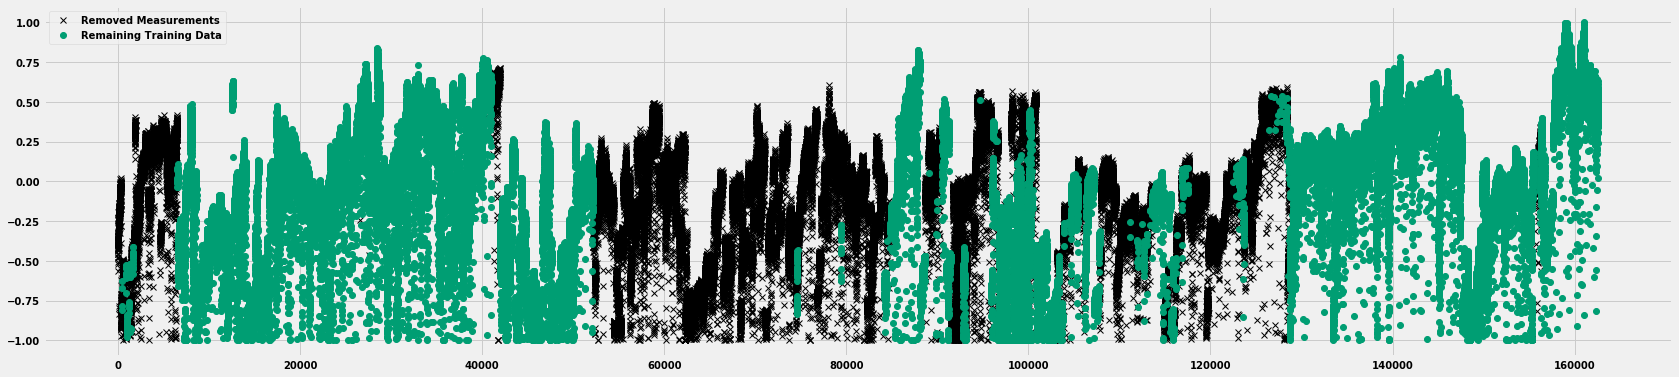

In [19]:
column = 63
a = -0.25
b = 0.25

allinds, remaining, xinds, xs, ys = qru.make_data_cuts(x_scaled, y_scaled, column, a, b, variable_names, verbose = True)

plt.figure(figsize = (26, 6))
plt.plot(xinds[0], y_scaled[xinds], 'x', color = colors[0], label = "Removed Measurements")
plt.plot(remaining, ys, '.', color = colors[-3], markersize = 12, label = "Remaining Training Data")
plt.legend()
plt.show()

q63 = qru.make_cut_dict(column, a, b, allinds, remaining, xinds, xs, ys)


In [23]:
training_models = False


PATH = ""
MODEL_NAME = "HXR/" + str(variable_names[column])+"_"
NN = MODEL_NAME + "median_pred_Model_Weights.h5"
LB = MODEL_NAME + "lower_pred_Model_Weights.h5"
UB = MODEL_NAME + "upper_pred_Model_Weights.h5"

if training_models:

    epochs = 5000
    batch_size = 4096
    PATH = "/global/cfs/cdirs/m669/lgupta/datasets/FEL/HXR/"



    median_q63 = qru.Model(scaling_dict = d, PATH = PATH, NAME = str(variable_names[column])+"_median_pred_", QUANTILE = 0.5)
    median_q63.train(q45["xs"], q45["ys"], epochs = epochs, batch_size = batch_size)
    print("Completed")

    upper_q63 = qru.Model(scaling_dict = d, PATH = PATH, NAME = str(variable_names[column])+"_upper_pred_", QUANTILE = 0.975)
    upper_q63.train(q45["xs"], q45["ys"], epochs = epochs, batch_size = batch_size)
    print("Completed")

    lower_q63 = qru.Model(scaling_dict = d, PATH = PATH, NAME = str(variable_names[column])+"_lower_pred_", QUANTILE = 0.025)
    lower_q63.train(q45["xs"], q45["ys"], epochs = epochs, batch_size = batch_size)
    print("Completed")
    
else:
    
    median_q63 = qru.Model(PATH = PATH, NAME = NN, scaling_dict = d)   
    median_q63.load()

    upper_q63 = qru.Model(PATH = PATH, NAME = UB, scaling_dict = d)   
    upper_q63.load()

    lower_q63 = qru.Model(PATH = PATH, NAME = LB, scaling_dict = d)   
    lower_q63.load()
    print("Models Loaded")

Models Loaded


In [24]:
inps = input_data
out = output_data
median_pred = median_q63.evaluate( inps)
ub_pred = upper_q63.evaluate(inps)
lb_pred = lower_q63.evaluate(inps)

/global/homes/l/lgupta/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


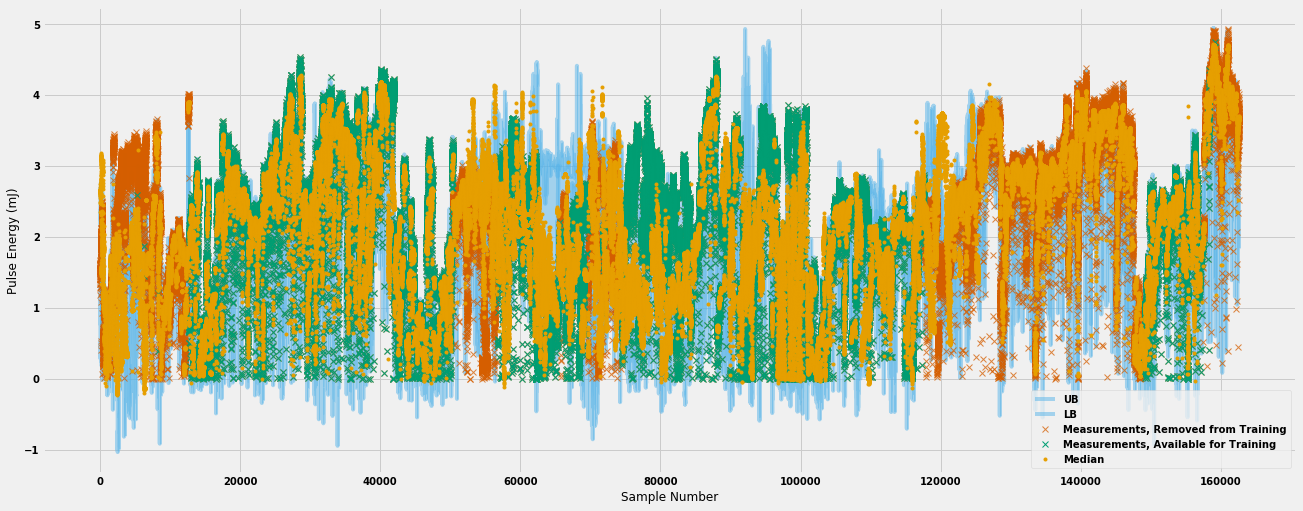

In [25]:
qru.plot_interpolation_predictions(ub_pred, lb_pred, median_pred, out, output_data, q45["remaining"])

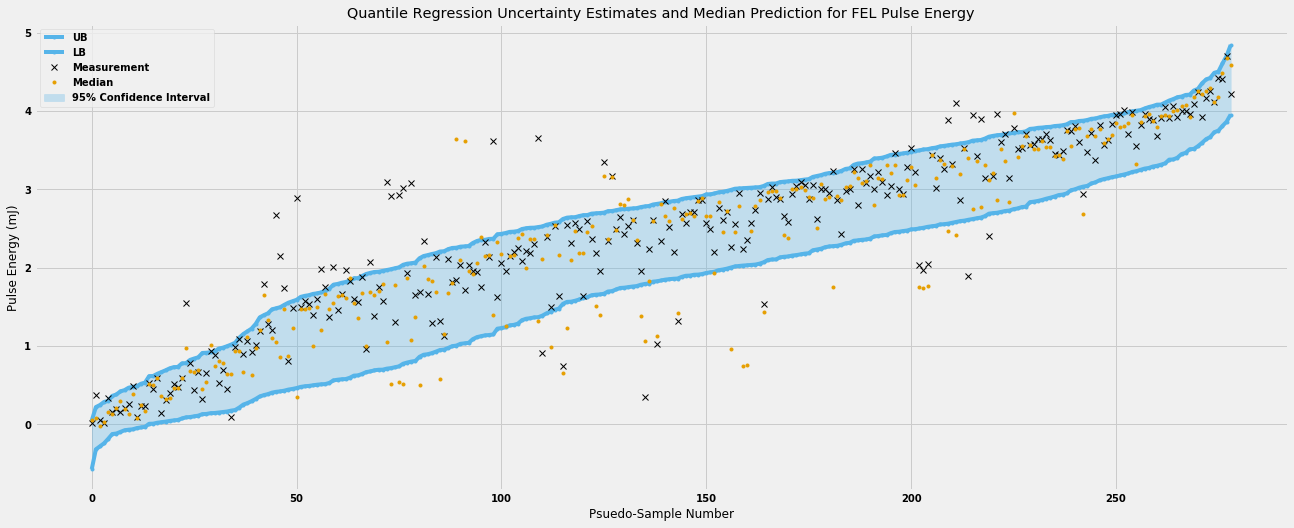

In [26]:
qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, out)

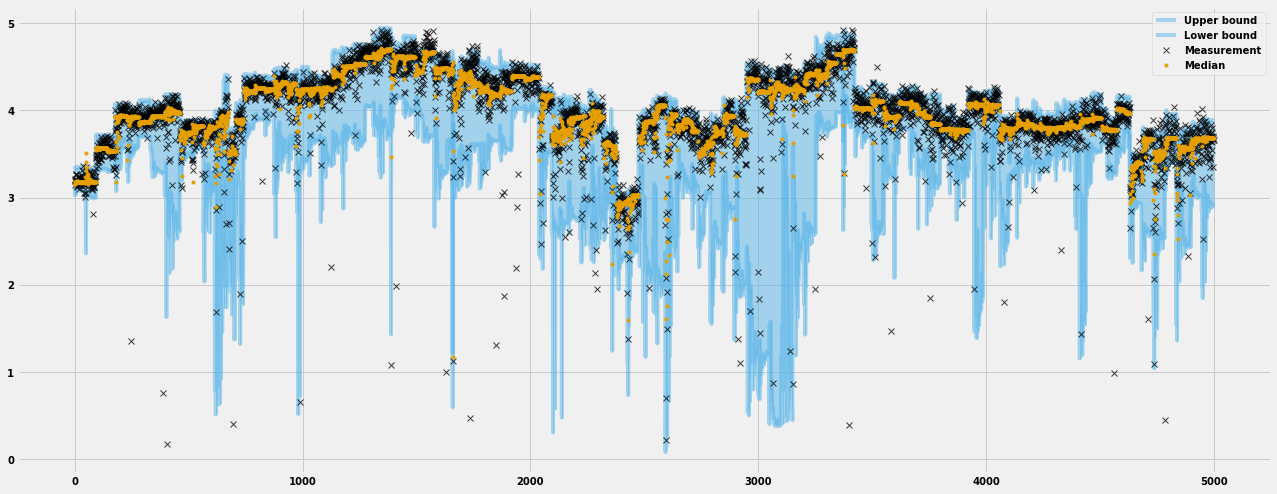

In [27]:
qru.basic_plotting(ub_pred[-5000:,:], lb_pred[-5000:,:], median_pred[-5000:,:], out[-5000:])

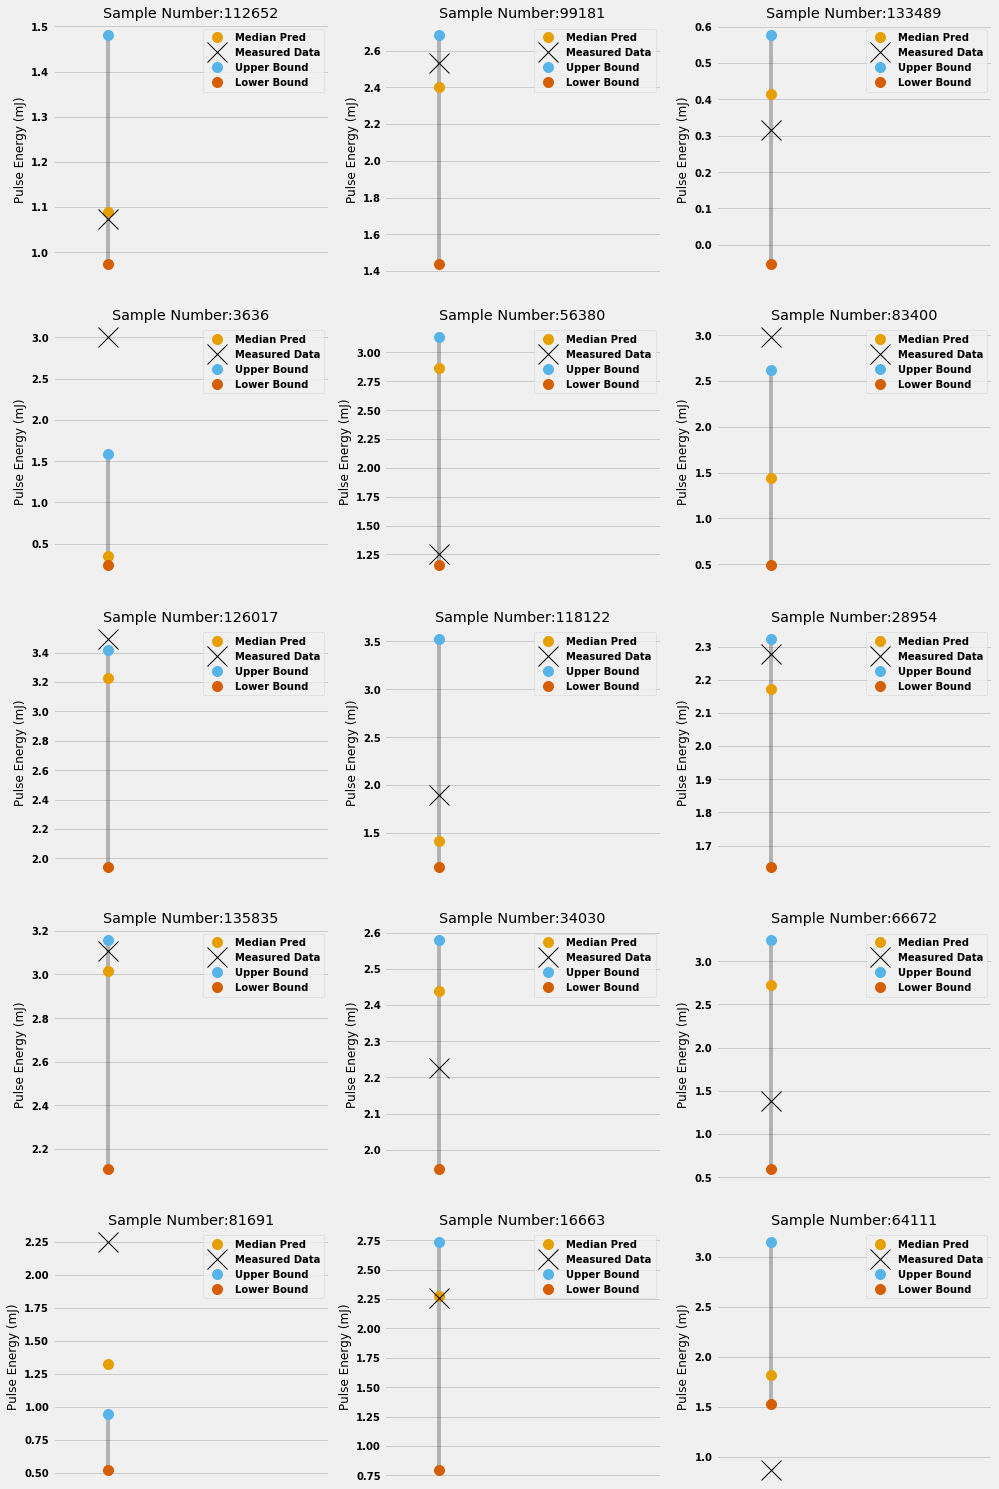

In [63]:
qru.plot_individual_points(ub_pred, lb_pred, median_pred,out)